# Simon's Algorithm

First algorithm with an exponential speed up and introduced the idea of quantum fourier transform.

## Problem

We have a blackbox function $f$ which can be either of these two cases:

- One-to-one: maps exactly one input for every unique output;
- Two-to-one: maps exactly two inputs for every unique output.

The condition two-to-one is specified accordingly to a hidden substring $b$:

$$
\text{given } x_1, x_2\text{: } f(x_1)=f(x_2)\\
\text{then we have that } x_1 \oplus x_2 = b
$$

The problem is to distinguish whether the function is actually one or two to one. If it is two-to-one, then we must also find the string $b$. Notice that the problem actually boils down to finding the string $b$ for any function, since the case o-t-o actually boils down to a t-t-o which has $b=(0,\dots,0)$, since then it must be that $x_1=x_2$.

### Classical algorithm

The classical algorithm to find $b$ with 100% certainty requires us to check, in the worst case, $2^{n-1}+1$ inputs for $n$ bits, i.e. 1 more than half of all the inputs. This is because we need to make sure the function is not o-t-o and this only happens checking more than half inputs. If we get two inputs with same output, we can stop and compute $b$.

Generally speaking, even if there are some algorithms that give some speedups, it requires exponential time.

## Quantum algorithm

First of all, the oracle $Q_f$ that implements the function is as usual:

$$
Q_f |x\rangle |a\rangle = |x\rangle |a \oplus f(x) \rangle \\
Q_f |x\rangle |0\rangle = |x\rangle |f(x) \rangle \\
$$

The algorithm uses the following steps:

1. We use two $n$ qubits quantum registers in the $|\psi_0 \rangle = |0^{\otimes n} \rangle |0^{\otimes n} \rangle$

2. Apply H to the first register 

$$
H^{\otimes n} | \psi_0 \rangle = |\psi_1 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x \rangle |0^{\otimes n} \rangle
$$

3. Apply the query function $Q_f$

$$
Q_f |\psi_1 \rangle = |\psi_2 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x \rangle |f(x) \rangle
$$

4. Now measure the second register. The state will collapse according to the value of $f(x)$ observed and, if the function is t-t-o, the first register will be left in a superposition of two states $x$ and $y = x \oplus b$, thus if we omit the second register we are left with
$$
|\psi_3 \rangle = \frac{1}{\sqrt{2}} \big( |x \rangle> + |y \rangle \big)
$$

5. Apply again an H to the first register
$$
|\psi_4 \rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{z \in \{0,1\}^{n}} \big[ (-1)^{x \cdot z} + (-1)^{y \cdot z} \big] |z \rangle
$$
At this point the first register will have left only terms $|z\rangle$ such that $(-1)^{x\cdot z}=(-1)^{y\cdot z}$ or

$$
\begin{aligned}
x \cdot z &= y \cdot z\\
x \cdot z &= x \oplus b \cdot z\\
x \cdot z &= x \cdot z \oplus b \cdot z\\
b \cdot z &= 0 \text{ (mod 2)}
\end{aligned}
$$

6. Measure the first register. The ouput will thus be an $z_1$ such that $b \cdot z_1 = 0 \text{ (mod 2)}$. If we repeat this algorithm $\approx n$ times so as to obtain $n$ different values of $z$, we will end up withe following system
$$
\begin{cases}
b \cdot z_1 &= 0\\
b \cdot z_2 &= 0\\
&\vdots\\
b \cdot z_n &= 0
\end{cases}
$$  
solving this system with the usual methods, we can thus find the value of $b$.

Thus we end up with an algorithm which runs in linear time, and thus has an exponential speed up with respect to the best know classical algorithm.

# Implementation

We implement Simon's algorithm for $n=3$ qubits and $b=110$.

In [1]:
# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.tools.monitor import job_monitor
# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle #already implemented oracle

The function `simon_oracle` creates a simon oracle (actually, a `QuantumCircuit` implementing the oracle) given a hidden bitstring $b$. The details will be given later.

As seen in algorithms before, measurements are only allowed at the end of the circuit. However, in this case we do not care about the second circuit and we need to actually measure the first register.

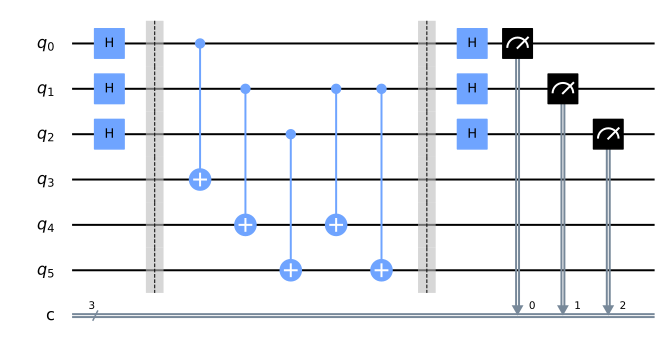

In [2]:
b = '110'
n = len(b)
#since simon_oracle returns a QuantumCircuit, I can't use my registers
#they are not considered as inputs to the oracle
#I can only use standard qubits
simon_circuit = QuantumCircuit(2*n, n)

simon_circuit.h(range(n))
simon_circuit.barrier()

#apply the oracle
simon_circuit += simon_oracle(b)

simon_circuit.barrier()
simon_circuit.h(range(n))

#we don't actually care about measuring the second register
#hence we measure only the first
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

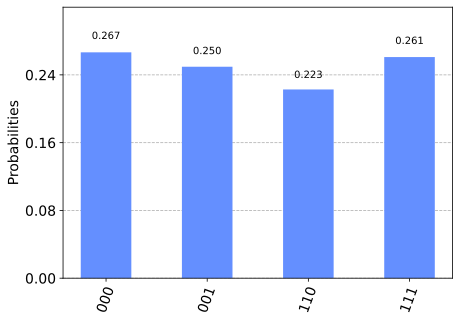

In [3]:
aer_backend = BasicAer.get_backend('qasm_simulator')
result = execute(simon_circuit, aer_backend, shots=5000).result().get_counts()
plot_histogram(result)

We know that $b=110$, so we can verify whether this result are what we would expect, i.e. if $b \cdot z = 0$ for all of them.

In [4]:
def bdotz(b,z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i])*int(z[i])
    return (accum % 2)

for z in result:
    print(f"{b}.{z} = {bdotz(b,z)} (mod 2)")

110.000 = 0 (mod 2)
110.001 = 0 (mod 2)
110.110 = 0 (mod 2)
110.111 = 0 (mod 2)


So the algorithm works. If we didn't already knew $b$, we could use these results to find out its value. Say we first measure $001$:

$$
\begin{aligned}
b \cdot 001 = 0 \text{ (mod 2)}\\
(b_2 \cdot 0) + (b_1 \cdot 0) +(b_0 \cdot 1) = 0\\
b_0 = 0
\end{aligned}
$$

If we next measured $111$:

$$
\begin{aligned}
b \cdot 111 = 0 \text{ (mod 2)}\\
(b_2 \cdot 1) + (b_1 \cdot 1) + \underbrace{(b_0 \cdot 1)}_{=0} = 0\\
(b_2 \cdot 1) + (b_1 \cdot 1) = 0
\end{aligned}
$$

which clearly tell us, remembering that $b_0 = 0$, that we have either 

$$b_2 = b_1 = 0 \implies b=000$$ 

or 

$$b_2 = b_1 = 1 \implies b=110$$

The last is the only non-trivial solution to our equation. We can solve this kind of problems with Gaussian elimination in O($n^3$).

If we want to be sure, we can try to apply $f$ to $x$ and $x \oplus b$ and check if these give the same output. We must have some kind of implementation of the oracle, so we can just apply that to the input qubits (assuming we don't still know $b$, here we must pas it as a parameter).

## Real device

The experiment above uses $2*n=6$ qubits, but many open IBM devices only have 5. We run the same code but with $b=11$ thus using only 4 qubits.

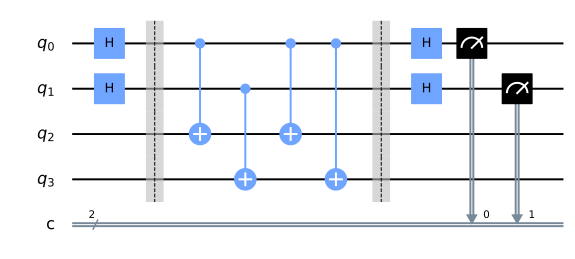

In [9]:
b_2 = '11'
n_2 = len(b_2)
#since simon_oracle returns a QuantumCircuit, I can't use my registers
#they are not considered as inputs to the oracle
#I can only use standard qubits
simon_circuit_2 = QuantumCircuit(2*n_2, n_2)

simon_circuit_2.h(range(n_2))
simon_circuit_2.barrier()

#apply the oracle
simon_circuit_2 += simon_oracle(b_2)

simon_circuit_2.barrier()
simon_circuit_2.h(range(n_2))

#we don't actually care about measuring the second register
#hence we measure only the first
simon_circuit_2.measure(range(n_2), range(n_2))
simon_circuit_2.draw()

This circuit is slightly different from the example one seen in qiskit book, but the output is the same: a 2-1 function such that $f(x)=f(x \oplus 11)$.

In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
IBMQ_backend_2 = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2*n_2 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", IBMQ_backend_2, " , Qubits: ", IBMQ_backend_2.configuration().n_qubits)

/home/luigi/.venvs/qiskit-textbook/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_valencia  , Qubits:  5


In [11]:
IBMQ_backend_3 = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2*n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", IBMQ_backend_3, " , Qubits: ", IBMQ_backend_3.configuration().n_qubits)

least busy backend:  ibmq_16_melbourne  , Qubits:  15


Job Status: job has successfully run


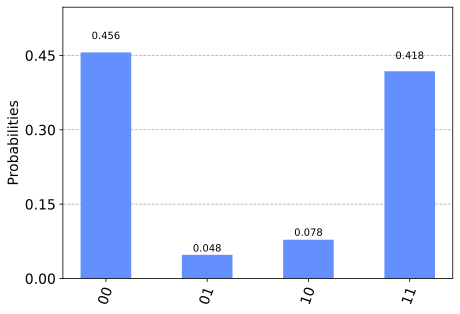

In [12]:
shots = 1024
job_2 = execute(simon_circuit_2, IBMQ_backend_2, shots=shots, optimization_level=3)
job_monitor(job_2, interval=2)
result_2 = job_2.result().get_counts()
plot_histogram(result_2)

As we saw in the example, we expect to measure only 00 and 11 since these are the only one such that $b \cdot z = 0$ with $b=11$. We can check our result as we did before

In [14]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b_2)
for z in result_2:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b_2, z, bdotz(b_2,z), result_2[z]*100/shots))


b = 11
11.00 = 0 (mod 2) (45.6%)
11.01 = 1 (mod 2) (4.8%)
11.10 = 1 (mod 2) (7.8%)
11.11 = 0 (mod 2) (41.8%)


and we see that the most common results are thos for which $b \cdot z =0$ as expected. If we ignore the erroneous results, we can then use a classical computer to solve this system of equation in $b$ with gaussian elimination.

We can actually run our 3 qubits algorithm `simon_circuit` too on a 15 qubits device.

Job Status: job has successfully run


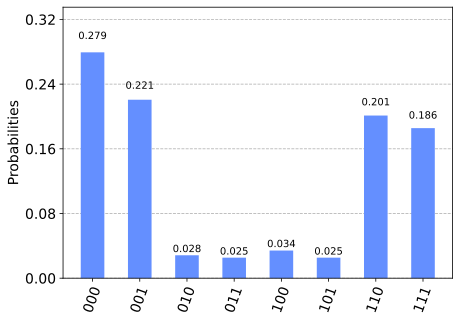

In [15]:
job_3 = execute(simon_circuit, IBMQ_backend_3, shots=shots, optimization_level=3)
job_monitor(job_3, interval=2)
result_3 = job_3.result().get_counts()
plot_histogram(result_3)

Here we see that we obtained the same 4 outputs we got with the simulator, except for some errors.

In [16]:
print('b = ' + b)
for z in result_3:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), result_3[z]*100/shots))

b = 110
110.000 = 0 (mod 2) (27.9%)
110.001 = 0 (mod 2) (22.1%)
110.010 = 1 (mod 2) (2.8%)
110.011 = 1 (mod 2) (2.5%)
110.100 = 1 (mod 2) (3.4%)
110.101 = 1 (mod 2) (2.5%)
110.110 = 0 (mod 2) (20.1%)
110.111 = 0 (mod 2) (18.6%)


And we see again that the most common results ($\approx 25\%$) are the expected one according to $b \cdot z = 0$, the others are errors.

## Oracle

We saw the Oracle functino for Simon's problem for some specific examples of $b$ and a few qubits. But we need to go in more detail to apply this problem to more qubits and bitstrings.

The Simon problem consists in finding the hidden bitstring $b \in \{0,1\}^n$ having just an oracle function $f_b$ that satisfies

$$
f_b(x) = f_b(y) \iff x \oplus y = b \quad \forall x,y \in \{0,1\}^n
$$

(the iff part was not clear from the beginning, now it's clearly stated). The $\oplus$ is of course the XOR operation, and is such that if $b=0$ then $x=y$ and we have a 1-1 function $f_b$ (i.e. a permutation). Otherwise, if $b \ne 0$ we have a 2-1 function $f_b$.

In the QC, the oracle is sent the state $|x\rangle|0\rangle$ with a predetermined $b$ string, and it must transform the state into the output state $|x\rangle|f_b(x)\rangle$ where $f_b$ is such that $f_b(x)=f_b(x \oplus b) \,\, \forall x$

We can realize such a function with the following procedure:

1. Copy the first register to the second $|x ,0 \rangle \rightarrow |x,x\rangle$
2. **(Create 1-1 or 2-1 mapping)** If $b \ne (0,\dots,0)$ then take the least index j such that $b_j=1$ (bit). If $x_j=0$ then XOR the second register with b. Otherwise, do not change the second register.

$$
|x, x \rangle \rightarrow |x, x \oplus b = y\rangle \quad \text{ if $x_j=0$ for the least index j}
$$

3. **(Create random permutation)** Last, randomly permute and flip the qubits of the second register to create various $f_b$

$$
|x, y \rangle \rightarrow |x, f_b(y) \rangle
$$

### Exercise

In [ ]:
def simon_oracle(b):
    n = len(b)
    j = 0
    for i in range(n):
        if b[i]==1:
            j=i
            break
    
    qc = QuantumCircuit(2*n,n)
    for q in range(n):
        qc.cx(q, q+n)
    if b != :
    

TypeError: unsupported operand type(s) for +: 'int' and 'range'